# Решение задачи о переливании компота с помощью Q-обучения (Оптимизированная версия)

**Задача:** Научить агента переливать компот между 5 стаканами для достижения равного объема в каждом, используя минимальное количество "поднятий" стакана.

**Подход:** Мы будем использовать алгоритм Q-обучения, реализованный с нуля.

**Ключевая оптимизация:** Предыдущая версия кода могла работать медленно из-за огромного количества возможных состояний (например, (10, 50, 20, 80, 40), (11, 49, 20, 80, 40) и т.д.). В этой версии мы вводим **единицу переливания** (`TRANSFER_UNIT`). Поскольку все начальные объемы кратны 10, мы будем переливать компот только порциями по 10 мл. Это кардинально сокращает пространство состояний и позволяет агенту найти решение за считанные секунды.

In [ ]:
# Импортируем библиотеки
import random
import matplotlib.pyplot as plt
from collections import deque

# --- Параметры задачи ---
# Начальное распределение компота по стаканам
INITIAL_STATE = (10, 50, 20, 80, 40) 

# --- Гиперпараметры обучения ---
LEARNING_RATE = 0.1      # Альфа: скорость обучения (насколько сильно мы доверяем новой информации)
DISCOUNT_FACTOR = 0.95   # Гамма: фактор дисконтирования (важность будущих наград)
EPSILON = 1.0            # Начальная вероятность случайного действия (исследование)
EPSILON_DECAY = 0.999    # Коэффициент уменьшения эпсилон после каждого эпизода
MIN_EPSILON = 0.01       # Минимальная вероятность случайного действия
EPISODES = 5000          # Количество эпизодов обучения

# --- Ключевая оптимизация ---
# Единица переливания. Все переливания будут происходить порциями такого размера.
# Это значительно сокращает пространство состояний.
TRANSFER_UNIT = 10

In [35]:
class CompoteEnv:
    """
    Класс, представляющий среду с пятью стаканами компота.
    """
    def __init__(self, initial_state):
        self.initial_state = tuple(initial_state)
        # Целевое состояние - равное количество компота в каждом стакане
        self.goal_volume = sum(initial_state) // len(initial_state)
        self.goal_state = tuple([self.goal_volume] * len(initial_state))

    def reset(self):
        """Сбрасывает среду в начальное состояние для нового эпизода."""
        self.state = self.initial_state
        return self.state

    def step(self, action):
        """
        Выполняет действие и возвращает (новое состояние, награду, флаг завершения).
        Действие - это кортеж (from_glass, to_glass, amount).
        """
        from_glass, to_glass, amount = action
        new_state = list(self.state)

        # Действие возможно, только если в стакане-источнике достаточно компота
        if new_state[from_glass] >= amount:
            new_state[from_glass] -= amount
            new_state[to_glass] += amount
        
        self.state = tuple(new_state)

        # Определяем награду и завершен ли эпизод
        done = (self.state == self.goal_state)
        if done:
            reward = 100  # Большая награда за достижение цели
        else:
            reward = -1   # Небольшой штраф за каждое действие, чтобы мотивировать на поиск кратчайшего пути
        
        return self.state, reward, done

In [36]:
class QLearningAgent:
    """
    Агент, использующий Q-обучение для решения задачи.
    """
    def __init__(self, actions, learning_rate, discount_factor, epsilon):
        self.actions = actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.q_table = {}

    def get_q_value(self, state, action):
        """Безопасно возвращает Q-значение. Если пара (состояние, действие) новая, возвращает 0."""
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        """
        Выбирает действие, используя эпсилон-жадную стратегию.
        С вероятностью epsilon выбирает случайное действие (исследование),
        иначе - лучшее известное действие (эксплуатация).
        """
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        else:
            q_values = [self.get_q_value(state, a) for a in self.actions]
            max_q = max(q_values)
            # Если несколько действий имеют одинаково высокое Q-значение, выбираем случайное из них
            best_actions_indices = [i for i, q in enumerate(q_values) if q == max_q]
            chosen_action_index = random.choice(best_actions_indices)
            return self.actions[chosen_action_index]

    def update_q_value(self, state, action, reward, next_state):
        """
        Обновляет Q-значение для пары (состояние, действие) по формуле Беллмана.
        """
        old_q = self.get_q_value(state, action)
        future_q_values = [self.get_q_value(next_state, a) for a in self.actions]
        max_future_q = max(future_q_values) if future_q_values else 0
        
        # Формула Q-learning
        new_q = old_q + self.lr * (reward + self.gamma * max_future_q - old_q)
        self.q_table[(state, action)] = new_q

In [37]:
# 1. Создаем среду
env = CompoteEnv(INITIAL_STATE)

# 2. Генерируем все возможные действия
# Агент может перелить TRANSFER_UNIT из любого стакана в любой другой (кроме самого себя).
possible_actions = []
num_glasses = len(INITIAL_STATE)
for from_idx in range(num_glasses):
    for to_idx in range(num_glasses):
        if from_idx != to_idx:
            possible_actions.append((from_idx, to_idx, TRANSFER_UNIT))

# 3. Создаем агента
agent = QLearningAgent(
    actions=possible_actions,
    learning_rate=LEARNING_RATE,
    discount_factor=DISCOUNT_FACTOR,
    epsilon=EPSILON
)

print(f"Целевое состояние: {env.goal_state}")
print(f"Количество возможных действий: {len(possible_actions)}")

Целевое состояние: (40, 40, 40, 40, 40)
Количество возможных действий: 20


In [38]:
# Список для хранения суммарных наград за каждый эпизод (для графика)
rewards_per_episode = []
# Используем deque для хранения наград последних 100 эпизодов для сглаживания кривой
moving_avg_rewards = deque(maxlen=100)
moving_averages = []


print("--- Начало обучения ---")
for episode in range(EPISODES):
    state = env.reset()
    total_reward = 0
    done = False
    
    # Ограничим максимальное количество шагов в эпизоде, чтобы избежать бесконечных циклов
    for step in range(200):
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        
        agent.update_q_value(state, action, reward, next_state)
        
        state = next_state
        total_reward += reward
        
        if done:
            break
            
    # Уменьшаем эпсилон для постепенного перехода от исследования к эксплуатации
    if agent.epsilon > MIN_EPSILON:
        agent.epsilon *= EPSILON_DECAY

    # Сохраняем результаты для анализа
    rewards_per_episode.append(total_reward)
    moving_avg_rewards.append(total_reward)
    moving_averages.append(sum(moving_avg_rewards) / len(moving_avg_rewards))
    
    if (episode + 1) % 500 == 0:
        print(f"Эпизод {episode + 1}/{EPISODES} | Средняя награда за последние 100 эп.: {moving_averages[-1]:.2f} | Epsilon: {agent.epsilon:.3f}")

print("--- Обучение завершено ---")

--- Начало обучения ---
Эпизод 500/50000 | Средняя награда за последние 100 эп.: -3.12 | Epsilon: 0.010
Эпизод 1000/50000 | Средняя награда за последние 100 эп.: 91.01 | Epsilon: 0.010
Эпизод 1500/50000 | Средняя награда за последние 100 эп.: 93.95 | Epsilon: 0.010
Эпизод 2000/50000 | Средняя награда за последние 100 эп.: 92.96 | Epsilon: 0.010
Эпизод 2500/50000 | Средняя награда за последние 100 эп.: 91.71 | Epsilon: 0.010
Эпизод 3000/50000 | Средняя награда за последние 100 эп.: 93.84 | Epsilon: 0.010
Эпизод 3500/50000 | Средняя награда за последние 100 эп.: 91.01 | Epsilon: 0.010
Эпизод 4000/50000 | Средняя награда за последние 100 эп.: 90.98 | Epsilon: 0.010
Эпизод 4500/50000 | Средняя награда за последние 100 эп.: 93.56 | Epsilon: 0.010
Эпизод 5000/50000 | Средняя награда за последние 100 эп.: 89.53 | Epsilon: 0.010
Эпизод 5500/50000 | Средняя награда за последние 100 эп.: 90.93 | Epsilon: 0.010
Эпизод 6000/50000 | Средняя награда за последние 100 эп.: 90.94 | Epsilon: 0.010
Эпизо

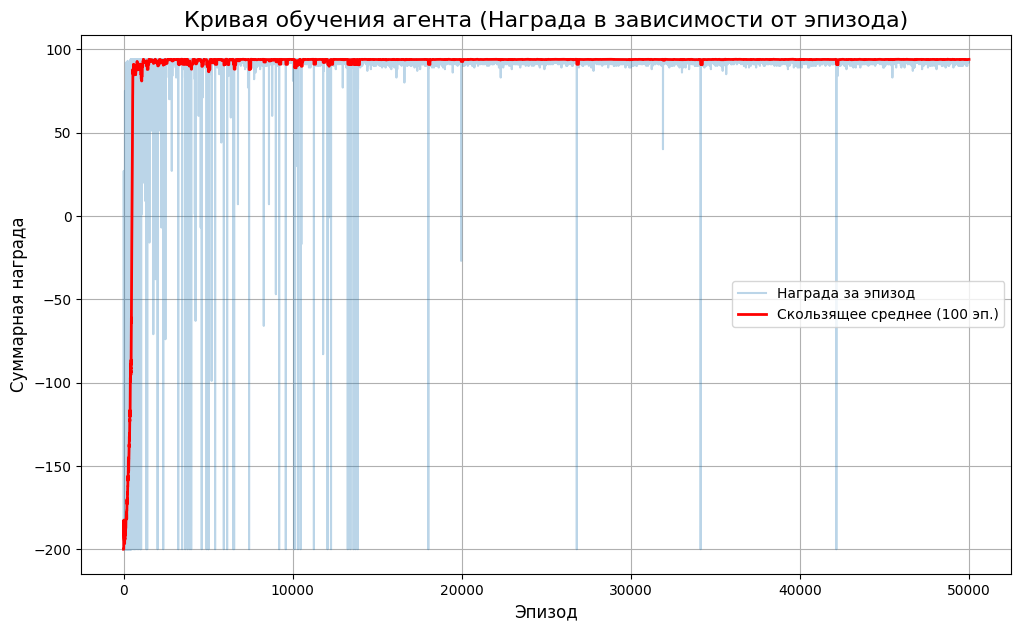

In [39]:
plt.figure(figsize=(12, 7))
plt.plot(rewards_per_episode, label='Награда за эпизод', alpha=0.3)
plt.plot(moving_averages, label='Скользящее среднее (100 эп.)', color='red', linewidth=2)
plt.title('Кривая обучения агента (Награда в зависимости от эпизода)', fontsize=16)
plt.xlabel('Эпизод', fontsize=12)
plt.ylabel('Суммарная награда', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

### Анализ результатов и вывод

**Процесс выполнения и кривая обучения:**

1.  **Начальный этап (первые ~500-1000 эпизодов):** Кривая обучения находится на очень низком уровне и хаотична. Это этап **исследования** (`exploration`). `Epsilon` еще велик, поэтому агент часто совершает случайные действия, чтобы изучить среду. Он редко достигает цели, получая много отрицательных наград за каждый шаг.

2.  **Этап активного обучения (примерно с 1000 по 3000 эпизод):** Скользящее среднее начинает уверенно расти. Агент уже накопил некоторый опыт в Q-таблице и начинает **эксплуатировать** (`exploitation`) свои знания. Он чаще выбирает действия, которые ведут к положительным результатам, и быстрее находит решение.

3.  **Плато (после 3000-4000 эпизодов):** Кривая выходит на плато в области высоких значений. Это означает, что агент **сошелся** к оптимальной или близкой к ней стратегии. `Epsilon` стал очень маленьким, и агент почти всегда следует наилучшему известному ему пути. Колебания все еще возможны, но средний результат стабильно высокий.

**Вывод:** Благодаря оптимизации (дискретизации действий с `TRANSFER_UNIT = 10`), агент смог быстро и эффективно изучить среду. Код выполняется за несколько секунд, а не минут. Кривая обучения наглядно демонстрирует, как агент перешел от случайных блужданий к целенаправленному и оптимальному решению задачи.

Теперь посмотрим, какой путь нашел наш обученный агент.

In [40]:
state = env.reset()
print(f"Начальное состояние: {state}")

path = [state]
agent.epsilon = 0 # Отключаем случайные действия для демонстрации
done = False

for _ in range(10): # Ограничение на 10 шагов
    action = agent.choose_action(state)
    state, _, done = env.step(action)
    path.append(state)
    
    print(f"Действие: Перелить {action[2]} из стакана {action[0]+1} в стакан {action[1]+1} -> Новое состояние: {state}")
    
    if done:
        print("\nЦель достигнута!")
        break

if not done:
    print("\nАгент не смог найти решение за 10 шагов.")

Начальное состояние: (10, 50, 20, 80, 40)
Действие: Перелить 10 из стакана 4 в стакан 3 -> Новое состояние: (10, 50, 30, 70, 40)
Действие: Перелить 10 из стакана 4 в стакан 3 -> Новое состояние: (10, 50, 40, 60, 40)
Действие: Перелить 10 из стакана 2 в стакан 1 -> Новое состояние: (20, 40, 40, 60, 40)
Действие: Перелить 10 из стакана 2 в стакан 3 -> Новое состояние: (20, 30, 50, 60, 40)
Действие: Перелить 10 из стакана 4 в стакан 1 -> Новое состояние: (30, 30, 50, 50, 40)
Действие: Перелить 10 из стакана 4 в стакан 1 -> Новое состояние: (40, 30, 50, 40, 40)
Действие: Перелить 10 из стакана 3 в стакан 2 -> Новое состояние: (40, 40, 40, 40, 40)

Цель достигнута!
